In [ ]:
#![title](./img/log.png "ShowMyImage")

# A Short Introduction to Boosting implementation -- AdaBoost
This is an implementation of the research paper ["A Short Introduction to Boosting"](http://www.cs.columbia.edu/~jebara/6772/papers/IntroToBoosting.pdf) written by Yoav Freund and Robert E. Schapire.

## Inspiration
Machine Learning algorithms specially those concerning classification and regression can perform weakly while encountering huge datasets. In order to overcome such inconveniences, a number of optimisation algorithms were developed that could improve a model's performance significantly. Adaboost is one such boosting technique which we have implemented here to analyse the improvement in the performance of our classification model.


<img src = "./img/ensem-2.png">
<hr>

## Introduction
Boosting refers to a general and provably effective method of producing a very accurate prediction rule by combining rough and moderately inaccurate rules of thumb. The AdaBoost algorithm was introduced in 1995 by Freund and Schapire which solved many of the practical difficulties of the earlier boosting algorithms. The algorithm takes as input a training set (x<sub>1</sub>,y<sub>1</sub>),...., (x<sub>m</sub>,y<sub>m</sub>) where each x<sub>i</sub> belongs to some domain or instance space, and each label y<sub>i</sub> is in some label set assuming Y = {-1, 1}. AdaBoost calls a given weak or base learning algorithm repeatedly in a series of rounds t = 1,..., T whose job is to find a weak hypothesis h<sub>t</sub> and outputs a final hypothesis H which is a weighted majority vote of the T weak hypotheses.

<img src = "./img/ensem-3.png">
<hr>

## Dataset
The Dataset used here is a Toy Dataset generated by utilising make_gaussian_quantiles from sklearn.datasets module. This generated our input variable X in a two dimensional plane equivalently explained to have two features and our target variable y which took either -1 or +1.

<img src = "./img/ensem-4.png">
<hr>

## Model Components
Our model architecture consists of the following components :-
- The weak learner was decided to be a Decision Tree Classifier with two leaf nodes.
- The output obtained from the weak learners were combined into a weighted sum that represented the final boosted output.

<hr>

## Adaboost Algorithm

<img src = "./img/ensem-5.png">

## Implementation Details
- The custom defined datagenerate module is used to generate the input and the target variables.
- The generated data is plotted in a two dimensional plane through another custom defined module named plot, for visualizing the input.
- The weak learners are defined as Decision Tree Classifiers with two leaf nodes and are used to make predictions for fifty iterations in our case.
- The weighted sum of all the weak learners are computed as the final boosting output to study the performance enhancement.
- Lastly, the decision boundaries are visualized using the visualize module for every iteration.
<hr>

## Results
- After 1st iteration - 

<img src = "./img/ensem-6.png">

- After 50 iterations - 

 <img src = "./img/ensem-7.png">
  
- Training error of Weak Hypothesis vs Training error of Final Hypothesis -

<img src = "./img/ensem-8.png">
  
<hr>




In [2]:
from typing import Optional                #Importing the required modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_adaboost(X: np.ndarray,               #Plot ± samples in 2D, optionally with decision boundary
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:

    assert set(y) == {-1, 1}                  #Setting the range of y values

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]                           #Plotting the input variables which corresponds to class '1'
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='green')

    X_neg = X[y == -1]                          #Plotting the input variables which corresponds to class '-1'
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        if list(np.unique(Z)) == [1]:           #Adding colors to the predicted classes
            fill_colors = ['g']
        else:
            fill_colors = ['b', 'g']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

In [3]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles

''' generating a toy dataset using a similar approach to sklearn documentation'''
def dataset(n,random_seed,classes):
    if random_seed:
        np.random.seed(random_seed)
        X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=classes)
        return X, y*2-1

In [4]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier


class AdaBoost:

    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None
        self.ada_errors = None

    def fit(self, X: np.ndarray, y: np.ndarray, iters: int):

        n = X.shape[0]

        # initlizing numpy arrays
        self.sample_weights = np.zeros(shape=(iters, n))
        self.stumps = np.zeros(shape=iters, dtype=object)
        self.stump_weights = np.zeros(shape=iters)
        self.errors = np.zeros(shape=iters)
        self.ada_errors = np.zeros(shape=iters)

        # initializing weights uniformly
        self.sample_weights[0] = np.ones(shape=n) / n

        for t in range(iters):
            # fitting weak learner
            curr_sample_weights = self.sample_weights[t]
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump = stump.fit(X, y, sample_weight=curr_sample_weights)

            # calculating error and stump weight from weak learner prediction
            stump_pred = stump.predict(X)
            err = curr_sample_weights[(stump_pred != y)].sum() / n
            stump_weight = np.log((1 - err) / err) / 2

            # updating sample weights
            new_sample_weights = (
                    curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
            )

            new_sample_weights /= new_sample_weights.sum()

            # updating sample weights for t+1
            if t+1 < iters:
                self.sample_weights[t+1] = new_sample_weights

            self.stumps[t] = stump
            self.stump_weights[t] = stump_weight
            self.errors[t] = err
            self.ada_errors[t] = np.prod(((self.errors[t]*(1-self.errors[t]))**1/2))

        return self

    def predict(self, X):
        return np.sign(np.dot(self.stump_weights, np.array([stump.predict(X) for stump in self.stumps])))

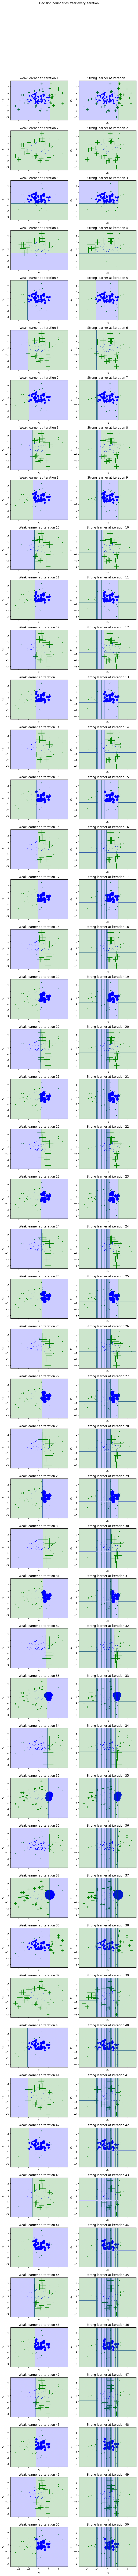

In [5]:
import matplotlib.pyplot as plt              #importing the required modules


def truncated_adaboost(clf, t: int):         #Truncate a fitted AdaBoost up to (and including) a particular iteration
    assert t > 0                               #t must be a positive integer
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf

def plot_iter_adaboost(X, y, clf, iters):       #Plot weak learner and cumulaive strong learner at each iteration.


    fig, axes = plt.subplots(figsize=(8, iters*3),        #larger grid
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    fig.set_facecolor('white')

    _ = fig.suptitle('Decision boundaries after every iteration')   #Plot the decision boundaries
    for i in range(iters):
        ax1, ax2 = axes[i]


        _ = ax1.set_title(f'Weak learner at iteration {i + 1}')     #Plot weak learner
        plot_adaboost(X, y, clf.stumps[i],
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax1)


        trunc_clf = truncated_adaboost(clf, t = i + 1)              #Plot strong learner
        _ = ax2.set_title(f'Strong learner at iteration {i + 1}')
        plot_adaboost(X, y, trunc_clf,
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

X, y = dataset(100,10,2)
clf = AdaBoost().fit(X, y, iters=50)
plot_iter_adaboost(X, y, clf, 50)

Train error: 0.0000%


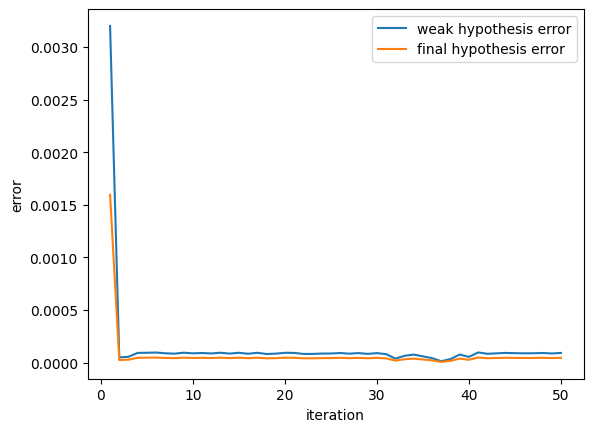

In [6]:
import matplotlib.pyplot as plt

X, y = dataset(100,10,2)

# assign our individually defined functions as methods of our classifier
clf = AdaBoost().fit(X, y, iters=50)

train_err = (clf.predict(X) != y).mean()
print(f'Train error: {train_err:.4%}')

errors = list(clf.errors)
ada_error = list(clf.ada_errors)

y = []
for i in range(1,51):
    y.append(i)

# plotting the error curve (expected - exponentially decreasing)
plt.plot(y,errors)
plt.plot(y,ada_error)
plt.ylabel('error')
plt.xlabel('iteration')
plt.legend(['weak hypothesis error', 'final hypothesis error'], loc='upper right')
plt.show()